
# Sistemas Inteligentes 2021-I
## Proyecto Final: Trip Advisor Hotel Reviews
### Integrantes: Juan Vargas, David Eslava, Juan Montoya

TripAdvisor es una paltaforma web desarrollada en EEUU la cual brinda reseñas de contenido, recomendaciones, indexado y foros para hoteles, viajes y restaurantes en muchos sitios alrededor del mundo.  
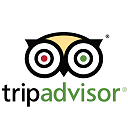  
Creada en Febrero del 2000 por por Stephen Kaufer, Langley Steinert, TripAdvisor se posiciona en una buena reputación dentro de los usuarios sienod uno de los sitios preferidos por los turistas a la hora de reservar y consultar distintos hoteles, viajes y restaurantes en el lugar de destino.  
TripAdvisor es una paltaforma en la cual los usuarios retroalimentan la información de los diferentes sitios que visitan aa traves de las reseñas que bridan, esta métrica permite tanto a los viajeros fijarse en determinados sitios de itneres según las recomendaciones y calidad de servicio, como para las empresas que brindan sus servicios los cuales les permite ganarse una reputación, darse a conocer y también mejorar constantemente el servicio según las opiniones que dan los turistas.  
Enfocandonos en esta métrica y exclusivamente al sector hotelero, TripAdvisor mide la calidad de estos sitios según las opiniones de sus visitantes, permitiendo hacer un comentario y dando una calificación de 1 a 5 estrellas en donde 5 estrellas es considerado un excelente servicio, y 1 estrella la peor calificación e inconformidad con el sitio.  
Tanto para la plataforma como para los hoteleros, es importante identificar que factores influyen en los clientes a la hora de calificar el servicio. Así como también que características son comunes dentro de cada una de las calificaciones.  
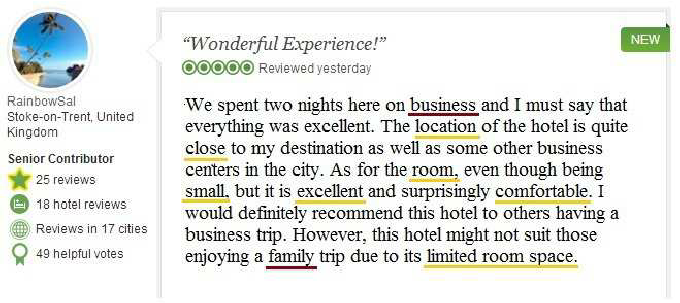

El objetivo de este proyecto es poder crear un sistema inteligente (Red neuronal) que pueda determinar las características principales de las reseñas que se tienen de los hoteles para uno de los 5 rangos de calificación posibles (1 estrellas, 2 estrellas, 3 estrellas, 4 estrellas y 5 estrellas)

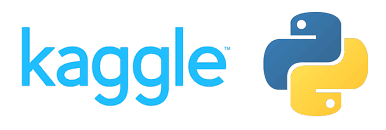

Para poder obtener dicha información, se hace provecho de **Kaggle** un sitio web que facilita la busqueda de información la cual está organizada y preparada para hacer ciencia de datos.  
Para realizar el modelo, se extrae el siguiente [dataset](https://www.kaggle.com/andrewmvd/trip-advisor-hotel-reviews)  el cual contiene la información de 20000 reseñas de hoteles junto con su respectiva calificación.


Pero antes que nada, se inicia la implementacióne importando las librerías necesarias

In [190]:
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #to generate cloud words
import string
from urllib.request import urlretrieve #to download from url 
import os
import csv
from tqdm import tqdm #bar progress
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from keras import layers, models
import tensorflow as tf

## 1.   Preparación de los datos
Primero se descargar el archivo y se leen los datos.  


In [8]:
if not os.path.isfile('tripadvisor_hotel_reviews.csv'):
    print("Downloading movie simple text file")
    conceptnet_url = 'https://raw.githubusercontent.com/jsmontoyaco/Sistemas-Inteligentes-Proyecto-Final/main/tripadvisor_hotel_reviews.csv'
    urlretrieve(conceptnet_url, 'tripadvisor_hotel_reviews.csv')

In [101]:
remove_punct=str.maketrans('','',string.punctuation)
ws = [] 
ys = [] 
cw = []
with open("tripadvisor_hotel_reviews.csv", mode="r", encoding='utf-8', errors='ignore') as f:
  f = csv.reader(f, delimiter=',')
  for l in tqdm(f):
    words = l[0].translate(remove_punct).lower().split()
    cw.append(l[0].translate(remove_punct).lower())
    y = int(l[1])
    ws.append(words)
    ys.append(y)
  
ys = np.array(ys)
cw = np.array(cw)

20491it [00:00, 21171.95it/s]


Pequeña vista de los datos

In [102]:
print(ws[0:5])
print(ys[0:5])
print(cw[0:5])

[['nice', 'hotel', 'expensive', 'parking', 'got', 'good', 'deal', 'stay', 'hotel', 'anniversary', 'arrived', 'late', 'evening', 'took', 'advice', 'previous', 'reviews', 'did', 'valet', 'parking', 'check', 'quick', 'easy', 'little', 'disappointed', 'nonexistent', 'view', 'room', 'room', 'clean', 'nice', 'size', 'bed', 'comfortable', 'woke', 'stiff', 'neck', 'high', 'pillows', 'not', 'soundproof', 'like', 'heard', 'music', 'room', 'night', 'morning', 'loud', 'bangs', 'doors', 'opening', 'closing', 'hear', 'people', 'talking', 'hallway', 'maybe', 'just', 'noisy', 'neighbors', 'aveda', 'bath', 'products', 'nice', 'did', 'not', 'goldfish', 'stay', 'nice', 'touch', 'taken', 'advantage', 'staying', 'longer', 'location', 'great', 'walking', 'distance', 'shopping', 'overall', 'nice', 'experience', 'having', 'pay', '40', 'parking', 'night'], ['ok', 'nothing', 'special', 'charge', 'diamond', 'member', 'hilton', 'decided', 'chain', 'shot', '20th', 'anniversary', 'seattle', 'start', 'booked', 'suit

## 2.  Análisis de Datos
Analicemos los datos de las reseñas, analizando la cantidad y proporción de cada calificación con respecto a las reseñas totales

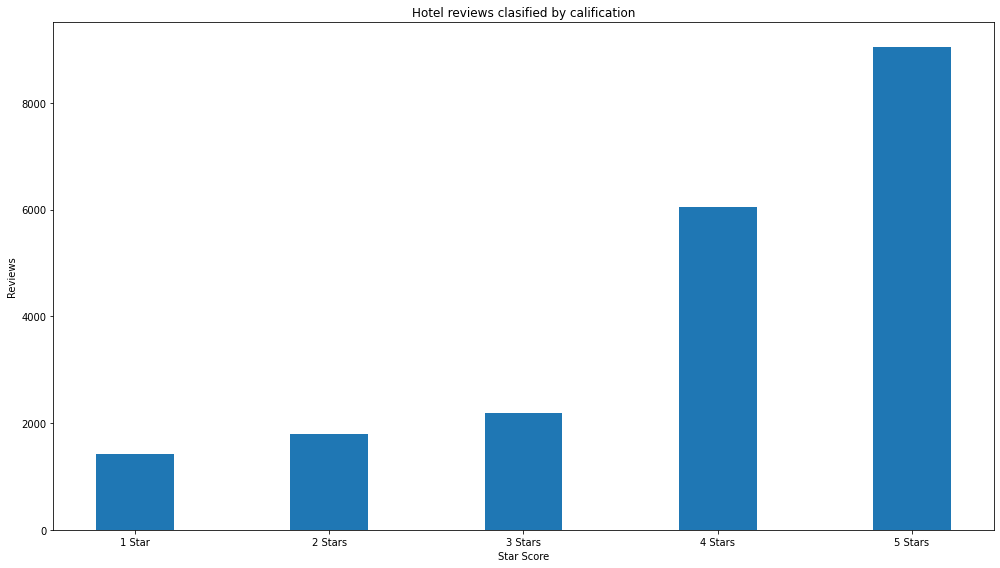

In [53]:
labels=['1 Star', '2 Stars', '3 Stars', '4 Stars', '5 Stars']
x = np.arange(len(labels))+1
plotdata = np.bincount(np.array(ys))[1:]
fig, ax = plt.subplots(figsize=(14,8))
ax.bar(x, plotdata, width=0.4)
ax.set_ylabel('Reviews')
ax.set_xlabel('Star Score')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_title('Hotel reviews clasified by calification')
fig.tight_layout()
plt.show()

Mirando la distribución porcentual

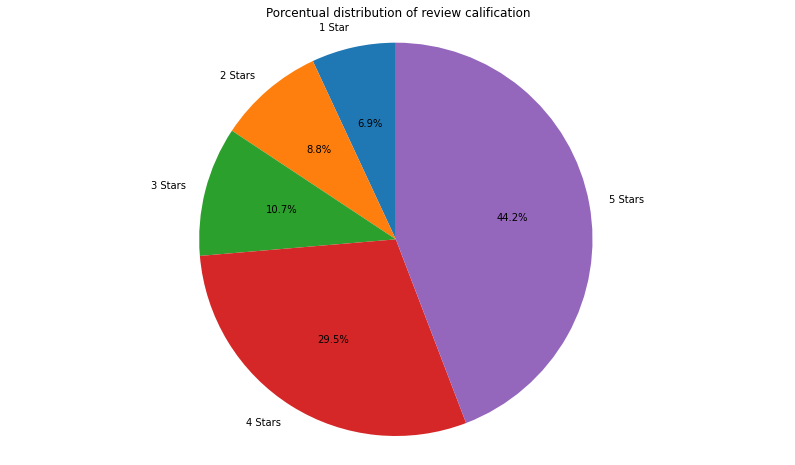

In [55]:
sizes = plotdata/sum(plotdata) *100
explode = (0,0,0,0,0)
fig2, ax2 = plt.subplots(figsize=(14,8))
ax2.pie(sizes, explode= explode, labels= labels, autopct='%1.1f%%', startangle=90)
ax2.axis('equal')
ax2.set_title('Porcentual distribution of review calification')
plt.show()

Como podemos ver, tenemos que en general más de la mitad de las calificaciones dadas por los usuarios son "buenas" estándo en el rango de 4 a 5 estrellas

Ahora el siguiente objetivo es ver que palabras son frecuentes dentro de las reseñas según su calificación, usando las herramientas gráficas de python se puede hacer una nube de palabras como mejor representación gráfica de la información.

In [151]:
words1s = np.take(cw, np.argwhere(ys==1))
strw1 = ' '.join(str(i) for i in words1s)
words2s = np.take(cw, np.argwhere(ys==2))
strw2 = ' '.join(str(i) for i in words2s)
words3s = np.take(cw, np.argwhere(ys==3))
strw3 = ' '.join(str(i) for i in words3s)
words4s = np.take(cw, np.argwhere(ys==4))
strw4 = ' '.join(str(i) for i in words4s)
words5s = np.take(cw, np.argwhere(ys==5))
strw5 = ' '.join(str(i) for i in words5s)

In [164]:
def cloudwordplot(cloudword, calification):
  # Create and generate a word cloud image:
  wordcloud = WordCloud(width=1400, height=800).generate(cloudword)

  # Display the generated image:
  plt.figure(figsize=(14,8))
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Common words in %1d Stars review' %(calification))
  plt.axis("off")
  plt.show()
 

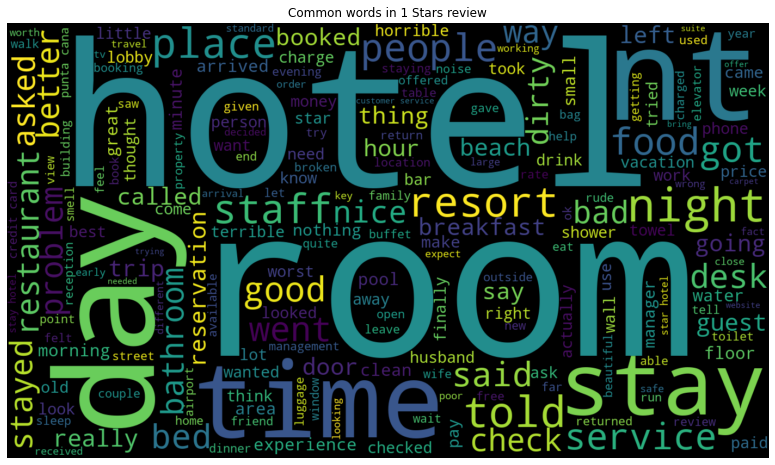

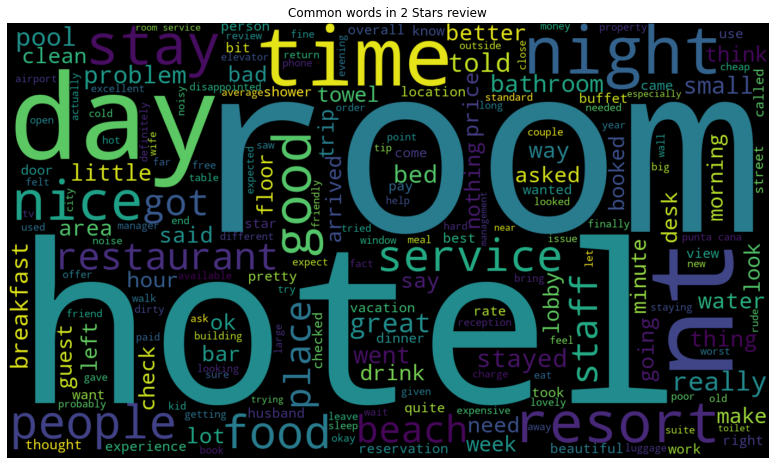

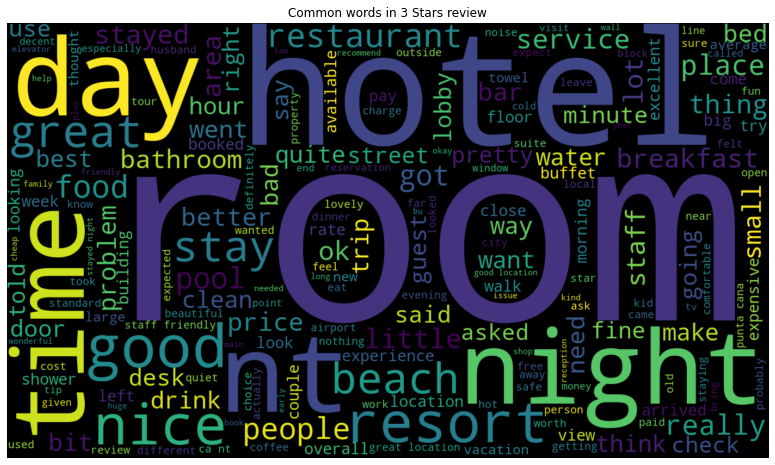

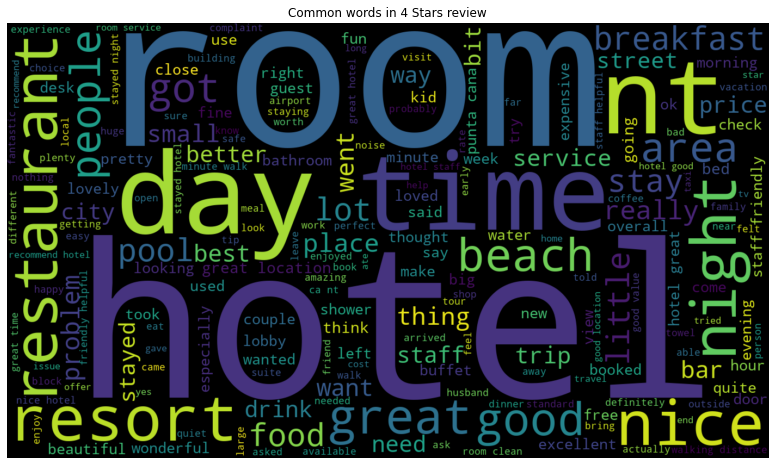

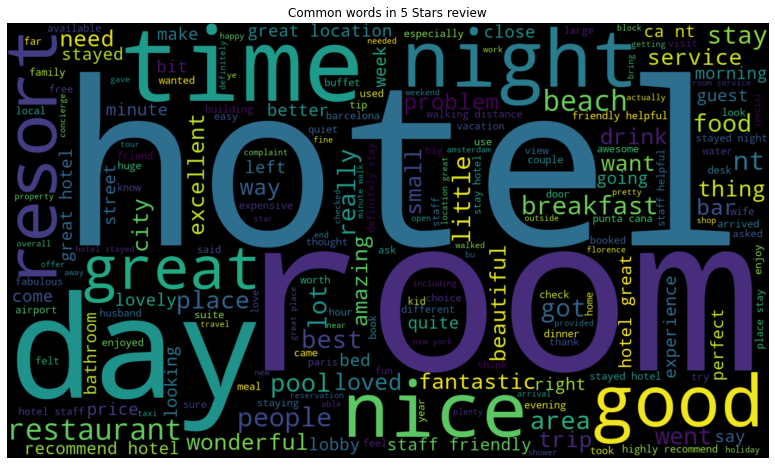

In [165]:
cloudwordplot(strw1,1)
cloudwordplot(strw2,2)
cloudwordplot(strw3,3)
cloudwordplot(strw4,4)
cloudwordplot(strw5,5)

## 3.  Implementación de una red neuronal para la predicción de datos
Ahora el objetivo es crear una red neuronal capaz de recibir una reseña y que sea capaz de predecir la calificación

### 3.1 creación del diccionario de palabras

In [167]:
vector = CountVectorizer()
new_X = vector.fit_transform(cw)
new_X

<20491x81405 sparse matrix of type '<class 'numpy.int64'>'
	with 1690181 stored elements in Compressed Sparse Row format>

In [168]:
new_X.shape

(20491, 81405)

In [169]:
vector.vocabulary_

{'nice': 49133,
 'hotel': 36856,
 'expensive': 28340,
 'parking': 53158,
 'got': 33531,
 'good': 33297,
 'deal': 21881,
 'stay': 68484,
 'anniversary': 6989,
 'arrived': 8188,
 'late': 42075,
 'evening': 27550,
 'took': 73394,
 'advice': 5250,
 'previous': 56485,
 'reviews': 60958,
 'did': 23127,
 'valet': 76903,
 'check': 16578,
 'quick': 57882,
 'easy': 25584,
 'little': 43154,
 'disappointed': 23558,
 'nonexistent': 49800,
 'view': 77461,
 'room': 61677,
 'clean': 17563,
 'size': 65745,
 'bed': 11072,
 'comfortable': 18524,
 'woke': 80061,
 'stiff': 68788,
 'neck': 48716,
 'high': 35983,
 'pillows': 54590,
 'not': 50030,
 'soundproof': 67050,
 'like': 42854,
 'heard': 35386,
 'music': 48242,
 'night': 49310,
 'morning': 47652,
 'loud': 43827,
 'bangs': 9924,
 'doors': 24520,
 'opening': 51429,
 'closing': 17892,
 'hear': 35383,
 'people': 53845,
 'talking': 70844,
 'hallway': 34758,
 'maybe': 45580,
 'just': 40885,
 'noisy': 49690,
 'neighbors': 48895,
 'aveda': 9082,
 'bath': 10446

In [171]:
V = vector.fit(cw)

In [172]:
vector.get_feature_names()

['00',
 '000',
 '0000',
 '0001',
 '000rp',
 '0030',
 '004',
 '005',
 '01',
 '0102where',
 '010504',
 '0114',
 '0123',
 '012305012905',
 '0126',
 '0130',
 '01st',
 '02',
 '0200',
 '020106',
 '021805',
 '025',
 '02505',
 '02l',
 '03',
 '0300',
 '031104',
 '03170324',
 '031804',
 '03182007',
 '0320',
 '032204',
 '03252007me',
 '0330',
 '033008',
 '033704',
 '0361',
 '04',
 '040',
 '0400',
 '040308',
 '04140420',
 '04hotel',
 '05',
 '050',
 '0500',
 '0500staff',
 '050405',
 '051704',
 '05190526',
 '052104',
 '0525',
 '05282007',
 '05292007',
 '0530',
 '0540',
 '055',
 '05firstly',
 '06',
 '060',
 '0600',
 '06012006',
 '060308',
 '060408',
 '060507i',
 '060908',
 '0610',
 '061408',
 '0616',
 '062703',
 '0630',
 '068',
 '069',
 '06the',
 '06there',
 '06we',
 '07',
 '0700',
 '070306we',
 '0705',
 '072608080908',
 '0730',
 '07300800',
 '0735',
 '075',
 '0764112570',
 '07first',
 '07hola',
 '07ok',
 '07the',
 '07we',
 '08',
 '0800',
 '08002200',
 '0809',
 '081',
 '0830',
 '0830am',
 '0840',
 '0

In [173]:
x_train, x_test, y_train, y_test = train_test_split(new_X, ys)

In [174]:
print(x_train.shape)
print(y_train.shape)

(15368, 81405)
(15368,)


###  3.2  Creación del modelo

In [177]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(81405,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax')) # Se quiere predecir que categoría tiene mayor probabilidad

In [178]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc']   
             )

In [192]:
x_val = x_train[:1000]
partial_x_train = x_train[1000:]

y_val = y_train[:1000]
partial_y_train =  y_train[1000:]

<1000x81405 sparse matrix of type '<class 'numpy.int64'>'
	with 79321 stored elements in Compressed Sparse Row format>

In [180]:
history = model.fit(partial_x_train,
                   partial_y_train,
                   epochs=9,
                   batch_size=512,
                   validation_data=(x_val,y_val))

InvalidArgumentError: ignored